## Customer Support Ticket Triage & Resolution Drafting

### Problem

Enterprises receive thousands of support tickets daily.
Manual triage causes:

Slow response times

Incorrect routing

Inconsistent replies

### Solution (LangGraph Sequential Workflow)

Automatically:

Classify the ticket

Determine priority

Draft a response

Prepare final structured output for CRM

In [9]:
import os
import json

from langgraph.graph import StateGraph, START, END
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from typing import TypedDict, Literal, Dict, Any, Annotated
import operator

from dotenv import load_dotenv
load_dotenv()

True

In [10]:
def get_llm() -> AzureChatOpenAI:

    api_key = os.getenv("AZURE_OPENAI_KEY")
    api_version = os.getenv("AZURE_OPENAI_VERSION", "2024-02-15-preview")
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    azure_deployment = (
        os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
        or os.getenv("AZURE_OPENAI_DEPLOYMENT")
    )

    # ---- Validation ----
    missing = []
    if not api_key:
        missing.append("AZURE_OPENAI_KEY")
    if not azure_endpoint:
        missing.append("AZURE_OPENAI_ENDPOINT")
    if not azure_deployment:
        missing.append("AZURE_OPENAI_DEPLOYMENT_NAME")

    if missing:
        raise EnvironmentError(
            f"Missing required environment variables: {', '.join(missing)}"
        )

    # Normalize endpoint
    azure_endpoint = azure_endpoint.rstrip("/")

    return AzureChatOpenAI(
        api_key=api_key,
        api_version=api_version,
        azure_endpoint=azure_endpoint,
        azure_deployment=azure_deployment,
        temperature=0.0,
    )


# Example usage
llm = get_llm()
# llm.invoke(
#     f"Answer the following question clearly:\n explain Molecule"
# )


In [11]:
from pydantic import BaseModel
from typing import Literal, TypedDict

class TicketMeta(BaseModel):
    category: Literal["Billing", "Technical", "Account", "Feature Request"]
    priority: Literal["Low", "Medium", "High", "Critical"]
    priority_reason: str

class DraftResponse(BaseModel):
    subject: str
    body: str

class FrontendResponse(BaseModel):
    ticket: TicketMeta
    response: DraftResponse
    status: Literal["PendingAgentReview"]


In [12]:
class SupportTicketState(TypedDict):
    ticket_text: str
    category: str
    priority: str
    priority_reason: str
    subject: str
    body: str
    frontend_payload: dict


In [13]:
def analyse_ticket(state: SupportTicketState) -> SupportTicketState:

    structured_llm = llm.with_structured_output(TicketMeta)

    result = structured_llm.invoke(state['ticket_text'])
    return {
        "category": result.category,
        "priority": result.priority,
        "priority_reason": result.priority_reason
    }

def draft_response(state: SupportTicketState) -> SupportTicketState:
    prompt = f"""
    Write a professional customer support response for the following ticket
    ticket: {state['ticket_text']} with the following category and priority
    Category: {state['category']}
    Priority: {state['priority']}
    """

    structured_llm = llm.with_structured_output(DraftResponse)
    result = structured_llm.invoke(prompt)
    return {
        "subject": result.subject,
        "body": result.body
    }

def format_response(state: SupportTicketState) -> SupportTicketState:
    payload = FrontendResponse(
        ticket=TicketMeta(
            category=state["category"],
            priority=state["priority"],
            priority_reason=state["priority_reason"]
        ),
        response=DraftResponse(
            subject=state["subject"],
            body=state["body"]
        ),
        status="PendingAgentReview"
    )

    return {
        "frontend_payload": payload.model_dump()
    }


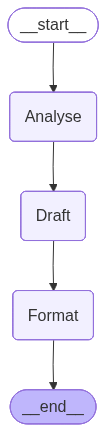

In [14]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(SupportTicketState)

workflow.add_node("Analyse", analyse_ticket)
workflow.add_node("Draft", draft_response)
workflow.add_node("Format", format_response)

workflow.set_entry_point("Analyse")
workflow.add_edge("Analyse", "Draft")
workflow.add_edge("Draft", "Format")
workflow.add_edge("Format", END)

graph = workflow.compile()
graph


In [15]:
ticket = """
My payment went through twice and I still cannot access my account.
This needs to be fixed urgently.
"""

result = graph.invoke({"ticket_text": ticket})

print(result)


{'ticket_text': '\nMy payment went through twice and I still cannot access my account.\nThis needs to be fixed urgently.\n', 'category': 'Billing', 'priority': 'Critical', 'priority_reason': 'Duplicate payment and account access issue require immediate resolution to prevent further inconvenience.', 'subject': 'Urgent Resolution for Billing Issue', 'body': "Dear [Customer's Name],\n\nThank you for reaching out to us regarding the issue with your payment and account access. We sincerely apologize for any inconvenience this has caused and appreciate your patience as we work to resolve this matter promptly.\n\nUpon reviewing your account, we have identified the duplicate payment and are currently investigating the cause of the access issue. Rest assured, we are prioritizing this matter and will ensure that your account is accessible as soon as possible. Additionally, we will address the duplicate payment to ensure proper resolution.\n\nWe will provide you with updates on the progress and r

In [16]:
print(result["frontend_payload"])

{'ticket': {'category': 'Billing', 'priority': 'Critical', 'priority_reason': 'Duplicate payment and account access issue require immediate resolution to prevent further inconvenience.'}, 'response': {'subject': 'Urgent Resolution for Billing Issue', 'body': "Dear [Customer's Name],\n\nThank you for reaching out to us regarding the issue with your payment and account access. We sincerely apologize for any inconvenience this has caused and appreciate your patience as we work to resolve this matter promptly.\n\nUpon reviewing your account, we have identified the duplicate payment and are currently investigating the cause of the access issue. Rest assured, we are prioritizing this matter and will ensure that your account is accessible as soon as possible. Additionally, we will address the duplicate payment to ensure proper resolution.\n\nWe will provide you with updates on the progress and resolution of this issue within the next [specific timeframe, e.g., 24 hours]. Should you have any f

In [20]:
import pandas as pd

pd.json_normalize(result["frontend_payload"])

,status,ticket.category,ticket.priority,ticket.priority_reason,response.subject,response.body
0,PendingAgentReview,Billing,Critical,Duplicate payment and account access issue req...,Urgent Resolution for Billing Issue,"Dear [Customer's Name],\n\nThank you for reach..."
